In [1]:
# set directory
#mydir<- getwd()
#setwd(mydir)

In [1]:

library(corrplot)
library(data.table)
library(edgeR, verbose=FALSE)
library(GenomicRanges, verbose=FALSE)
library(pheatmap)
library(RColorBrewer)
library(statmod, verbose=FALSE)

corrplot 0.92 loaded

Loading required package: limma

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are masked from ‘package:base’:

    I, expand.grid, unna

In [2]:
my_counts <- read.table("./data/rna_count_matrix_pairedTG.txt", row.names=1, header=TRUE)
head(my_counts)
dim(my_counts)

,PDX4_TG_CR1_Aligned.sortedByCoord.out.bam,PDX4_TG_CR2_Aligned.sortedByCoord.out.bam,PDX4_TG_CR3_Aligned.sortedByCoord.out.bam,PDX4_TG_SE1_Aligned.sortedByCoord.out.bam,PDX4_TG_SE2_Aligned.sortedByCoord.out.bam,PDX4_TG_SE3_Aligned.sortedByCoord.out.bam
,<int>,<int>,<int>,<int>,<int>,<int>
5S_rRNA,2,4,3,1,2,2
5_8S_rRNA,55577,54187,42697,40119,35530,60546
7SK,0,1,0,0,2,1
A1BG,1,1,2,4,0,0
A1BG-AS1,17,22,13,35,27,22
A1CF,0,0,0,1,0,2


[1] 39629     6

In [4]:
colnames(my_counts) <- substr(colnames(my_counts), 1, 11)
head(my_counts)

,PDX4_TG_CR1,PDX4_TG_CR2,PDX4_TG_CR3,PDX4_TG_SE1,PDX4_TG_SE2,PDX4_TG_SE3
,<int>,<int>,<int>,<int>,<int>,<int>
5S_rRNA,2,4,3,1,2,2
5_8S_rRNA,55577,54187,42697,40119,35530,60546
7SK,0,1,0,0,2,1
A1BG,1,1,2,4,0,0
A1BG-AS1,17,22,13,35,27,22
A1CF,0,0,0,1,0,2


In [5]:
pdata <- read.delim("./data/pdata_paired.txt", sep=",",comment.char="#", as.is=TRUE, header=TRUE)
pdata

run,source_name,treatment,replicate
<chr>,<chr>,<chr>,<int>
PDX4_TG_SE1,PDX4,sensitive,1
PDX4_TG_SE2,PDX4,sensitive,2
PDX4_TG_SE3,PDX4,sensitive,3
PDX4_TG_CR1,PDX4,resistant,1
PDX4_TG_CR2,PDX4,resistant,2
PDX4_TG_CR3,PDX4,resistant,3


All the information that we need for the current analysis is in two columns. And we need to get the subset of  our 8 samples from the whole set.

In [6]:
pdata <- pdata[,c("run", "treatment")]
pdata

run,treatment
<chr>,<chr>
PDX4_TG_SE1,sensitive
PDX4_TG_SE2,sensitive
PDX4_TG_SE3,sensitive
PDX4_TG_CR1,resistant
PDX4_TG_CR2,resistant
PDX4_TG_CR3,resistant


In [7]:
colnames(pdata) <- c("run", "treatment")

We need a column for **group** that we will use with **edgeR**.  We can make short descriptive group names based on the description column.  

In [8]:
my_groups <- pdata$treatment
my_groups

[1] "sensitive" "sensitive" "sensitive" "resistant" "resistant" "resistant"

In [9]:
pdata$group <- my_groups
pdata

run,treatment,group
<chr>,<chr>,<chr>
PDX4_TG_SE1,sensitive,sensitive
PDX4_TG_SE2,sensitive,sensitive
PDX4_TG_SE3,sensitive,sensitive
PDX4_TG_CR1,resistant,resistant
PDX4_TG_CR2,resistant,resistant
PDX4_TG_CR3,resistant,resistant


The variable group needs to be converted to a **factor** for **edgeR**.  

In [10]:
pdata$group <- as.factor(pdata$group)
table(pdata$group)


resistant sensitive 
        3         3 

Confirm that "BPH" control is set as the reference level, i.e. control.  **The reference level is always listed first.** In this case, we reorder the levels so BPH was set as the reference level.  

In [11]:
pdata$group <- factor(pdata$group, levels=c("sensitive", "resistant"))
levels(pdata$group)
pdata <- pdata[order(pdata$group),]
pdata

[1] "sensitive" "resistant"

,run,treatment,group
,<chr>,<chr>,<fct>
1,PDX4_TG_SE1,sensitive,sensitive
2,PDX4_TG_SE2,sensitive,sensitive
3,PDX4_TG_SE3,sensitive,sensitive
4,PDX4_TG_CR1,resistant,resistant
5,PDX4_TG_CR2,resistant,resistant
6,PDX4_TG_CR3,resistant,resistant


A descriptive label for the individual samples in each group will be useful for plots and processed datasets.

In [12]:
pdata$sample.label <- paste(pdata$group, 1:3, sep=".")
pdata<-pdata[order(pdata$group),]
pdata

,run,treatment,group,sample.label
,<chr>,<chr>,<fct>,<chr>
1,PDX4_TG_SE1,sensitive,sensitive,sensitive.1
2,PDX4_TG_SE2,sensitive,sensitive,sensitive.2
3,PDX4_TG_SE3,sensitive,sensitive,sensitive.3
4,PDX4_TG_CR1,resistant,resistant,resistant.1
5,PDX4_TG_CR2,resistant,resistant,resistant.2
6,PDX4_TG_CR3,resistant,resistant,resistant.3


Now, we are ready to send the data to **edgeR**.  The basic object class for edgeR is a **DGEList**.  You need a gene count matrix and group assignments.

# edgeR

## Making the DGEList
Now we are ready to start the **edgeR** analysis.  The first step is to format the count data and phenodata as a **DGEList** object. 

In [13]:
# first, reorder counts matrix to match with phenodata
my_counts<-my_counts[,pdata$run]
head(my_counts)

,PDX4_TG_SE1,PDX4_TG_SE2,PDX4_TG_SE3,PDX4_TG_CR1,PDX4_TG_CR2,PDX4_TG_CR3
,<int>,<int>,<int>,<int>,<int>,<int>
5S_rRNA,1,2,2,2,4,3
5_8S_rRNA,40119,35530,60546,55577,54187,42697
7SK,0,2,1,0,1,0
A1BG,4,0,0,1,1,2
A1BG-AS1,35,27,22,17,22,13
A1CF,1,0,2,0,0,0


In [14]:
## make DGE object
my_dge <- DGEList(counts = my_counts, group = pdata$group)
my_dge$samples$sample.label <- pdata$sample.label
head(my_dge)

An object of class "DGEList"
$counts
          PDX4_TG_SE1 PDX4_TG_SE2 PDX4_TG_SE3 PDX4_TG_CR1 PDX4_TG_CR2
5S_rRNA             1           2           2           2           4
5_8S_rRNA       40119       35530       60546       55577       54187
7SK                 0           2           1           0           1
A1BG                4           0           0           1           1
A1BG-AS1           35          27          22          17          22
A1CF                1           0           2           0           0
          PDX4_TG_CR3
5S_rRNA             3
5_8S_rRNA       42697
7SK                 0
A1BG                2
A1BG-AS1           13
A1CF                0

$samples
                group lib.size norm.factors sample.label
PDX4_TG_SE1 sensitive  4718707            1  sensitive.1
PDX4_TG_SE2 sensitive  4727596            1  sensitive.2
PDX4_TG_SE3 sensitive  4604115            1  sensitive.3
PDX4_TG_CR1 resistant  4112675            1  resistant.1
PDX4_TG_CR2 resistant  4105990            1  resistant.2
PDX4_TG_CR3 resistant  4741992            1  resistant.3

## Filtering the Data

We need to remove genes that are not expressed at a certain threshold.  Where you set this threshold is a matter of debate.  Certainly genes with no counts in any sample should be removed.

In [15]:
all_zeroes <- apply(my_dge$counts, 1, sum) == 0
table(all_zeroes)

all_zeroes
FALSE  TRUE 
21812 17817 

This shows that there are 14,729 genes that do not appear to be expressed in any sample.  If you wanted to be very conservative, this would be an acceptable filter, i.e. simply drop all the genes with no counts.  Generally, a less conservative strategy is recommended that takes into account the library size.  To do this, we need to convert the raw counts to Counts Per Million (cpm).  There is an **edgeR** function for this.   

In [16]:
my_cpm <- cpm(my_dge, normalized.lib.size=FALSE, log=FALSE)
head(my_cpm)

,PDX4_TG_SE1,PDX4_TG_SE2,PDX4_TG_SE3,PDX4_TG_CR1,PDX4_TG_CR2,PDX4_TG_CR3
5S_rRNA,0.2119225,0.423048,0.434394,4.863015e-01,9.741865e-01,0.6326455
5_8S_rRNA,8502.1172113,7515.447597,13150.410014,1.351359e+04,1.319706e+04,9004.0219385
7SK,0.0000000,0.423048,0.217197,0.000000e+00,2.435466e-01,0.0000000
A1BG,0.8476898,0.000000,0.000000,2.431507e-01,2.435466e-01,0.4217637
A1BG-AS1,7.4172861,5.711148,4.778334,4.133563e+00,5.358026e+00,2.7414639
A1CF,0.2119225,0.000000,0.434394,0.000000e+00,0.000000e+00,0.0000000


There is still the question of what CPM threshold to use for expression.  I have seen values from 0.1 to 10 used.  I think that both are extreme, and I typically use 1.  With that, we can convert the CPM matrix to a **logical** matrix that shows whether the CPM is greater than 1 or not.

In [17]:
expressed <- apply(my_cpm, 2, function(x)(x >= 1))
expressed[1:10, ]

,PDX4_TG_SE1,PDX4_TG_SE2,PDX4_TG_SE3,PDX4_TG_CR1,PDX4_TG_CR2,PDX4_TG_CR3
5S_rRNA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
5_8S_rRNA,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
7SK,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
A1BG,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
A1BG-AS1,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
A1CF,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
A2M,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
A2M-AS1,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE
A2ML1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
A2ML1-AS1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


Again, we have another cutoff choice.  Does a gene need to be expressed in only one sample or multiple samples to be retained?  We could use the logic that a gene might be expressed under only one biological condition (group).  Therefore, we set the cutoff to 2, i.e. the number of biological replicates in each group.

In [18]:
keep <- apply(expressed, 1, sum) >= 3
table(keep)

keep
FALSE  TRUE 
25985 13644 

So, we are going to discard about half of our features due to low or no expression.  Note, some packages such as **DESeq2** optimize this parameter for you.  

Now, we can recreate the **DGEList**, filtering the count matrix to remove unexpressed genes.

In [19]:
my_dge <- DGEList(counts = my_counts[keep, ], group = pdata$group)
my_dge$samples$sample.label <- pdata$sample.label
my_dge <- calcNormFactors(my_dge, method="TMM")
my_dge

,PDX4_TG_SE1,PDX4_TG_SE2,PDX4_TG_SE3,PDX4_TG_CR1,PDX4_TG_CR2,PDX4_TG_CR3
5_8S_rRNA,40119,35530,60546,55577,54187,42697
A1BG-AS1,35,27,22,17,22,13
A2M-AS1,8,9,11,5,4,9
AAAS,202,207,206,153,192,194
AACS,98,92,88,63,90,89
AADAT,54,76,65,68,75,90
AAGAB,129,137,100,81,74,103
AAK1,273,214,251,155,184,279
AAMDC,50,51,54,43,20,49
AAMP,496,434,433,516,448,609


## Normalizing the Libraries

A **HUGE** issue with any NGS experiment is normalization.  Rarely do you get back the same number of reads for each library.  If you do, often you will get different alignment efficiencies that will affect the gene count matrix.

This is one parameter that I typically leave the defaults.  The TMM method can account for over-representation of specific genes in one library over another.  For example, if rRNA is abundant in a particular sample, not only will the rRNA levels be high, but other genes may be under-sequenced because the rRNA sequences consumed the sequencing resource.  For more information, see [Robinson and Oshlack](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2864565/).

**edgeR** does provide alternative normalization methods.  In addition, it is possible to normalize your count matrix with other software before you convert it to a **DGEList**.  

In [20]:
my_dge <- calcNormFactors(my_dge, method="TMM")
my_dge

,PDX4_TG_SE1,PDX4_TG_SE2,PDX4_TG_SE3,PDX4_TG_CR1,PDX4_TG_CR2,PDX4_TG_CR3
5_8S_rRNA,40119,35530,60546,55577,54187,42697
A1BG-AS1,35,27,22,17,22,13
A2M-AS1,8,9,11,5,4,9
AAAS,202,207,206,153,192,194
AACS,98,92,88,63,90,89
AADAT,54,76,65,68,75,90
AAGAB,129,137,100,81,74,103
AAK1,273,214,251,155,184,279
AAMDC,50,51,54,43,20,49
AAMP,496,434,433,516,448,609


If you scroll down to the samples data, you will see that a column named **norm.factors** has been added.  If you compare the **norm.factors** to the **lib.size**, you should see that the normalization is not a simple scaling factor based only on the size of the libraries.  

### Counts Per Million
It is always a good idea to visualize your data before you proceed.  First, we need to make the CPM matrix again.  We will do it both for raw and normalized counts.  

In [21]:
cpm_raw <- cpm(my_dge, normalized.lib.size=FALSE, log=FALSE)
cpm_norm <- cpm(my_dge, normalized.lib.size=TRUE, log=FALSE)

In [22]:
head(cpm_raw)

,PDX4_TG_SE1,PDX4_TG_SE2,PDX4_TG_SE3,PDX4_TG_CR1,PDX4_TG_CR2,PDX4_TG_CR3
5_8S_rRNA,8520.906263,7530.080584,13177.138559,13533.669072,1.321740e+04,9019.396021
A1BG-AS1,7.433678,5.722268,4.788046,4.139705,5.366282e+00,2.746145
A2M-AS1,1.699126,1.907423,2.394023,1.217560,9.756876e-01,1.901177
AAAS,42.902940,43.870720,44.833524,37.257343,4.683300e+01,40.980931
AACS,20.814298,19.498098,19.152185,15.341259,2.195297e+01,18.800530
AADAT,11.469103,16.107124,14.146500,16.558819,1.829414e+01,19.011772


In [23]:
head(cpm_norm)

,PDX4_TG_SE1,PDX4_TG_SE2,PDX4_TG_SE3,PDX4_TG_CR1,PDX4_TG_CR2,PDX4_TG_CR3
5_8S_rRNA,8535.125236,7689.432305,13280.935482,13813.418602,1.345026e+04,8423.267899
A1BG-AS1,7.446082,5.843363,4.825762,4.225275,5.460826e+00,2.564641
A2M-AS1,1.701962,1.947788,2.412881,1.242728,9.928775e-01,1.775521
AAAS,42.974533,44.799113,45.186680,38.027476,4.765812e+01,38.272337
AACS,20.849031,19.910717,19.303048,15.658373,2.233974e+01,17.557928
AADAT,11.488242,16.447984,14.257933,16.901101,1.861645e+01,17.755208


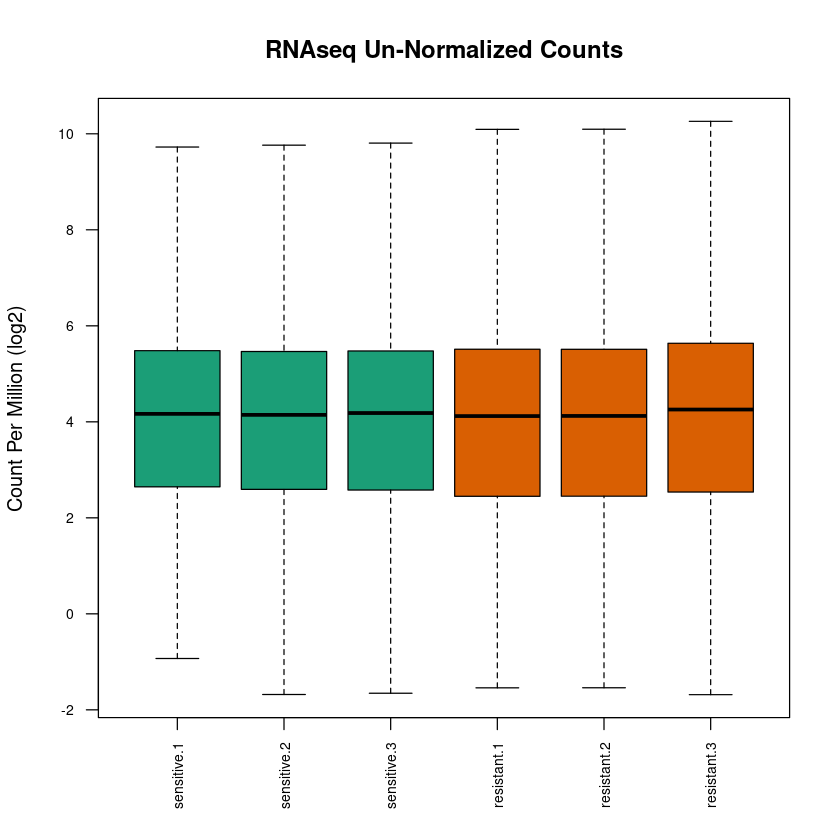

In [24]:
#library(RColorBrewer)
group_pal <- brewer.pal(4, "Dark2")
group_cols <- group_pal[my_dge$samples$group]
boxplot(log2(cpm_raw + 0.1), col=group_cols, las=2, outline=FALSE, names=pdata$sample.label, cex.axis=0.7, 
        main="RNAseq Un-Normalized Counts", ylab="Count Per Million (log2)")

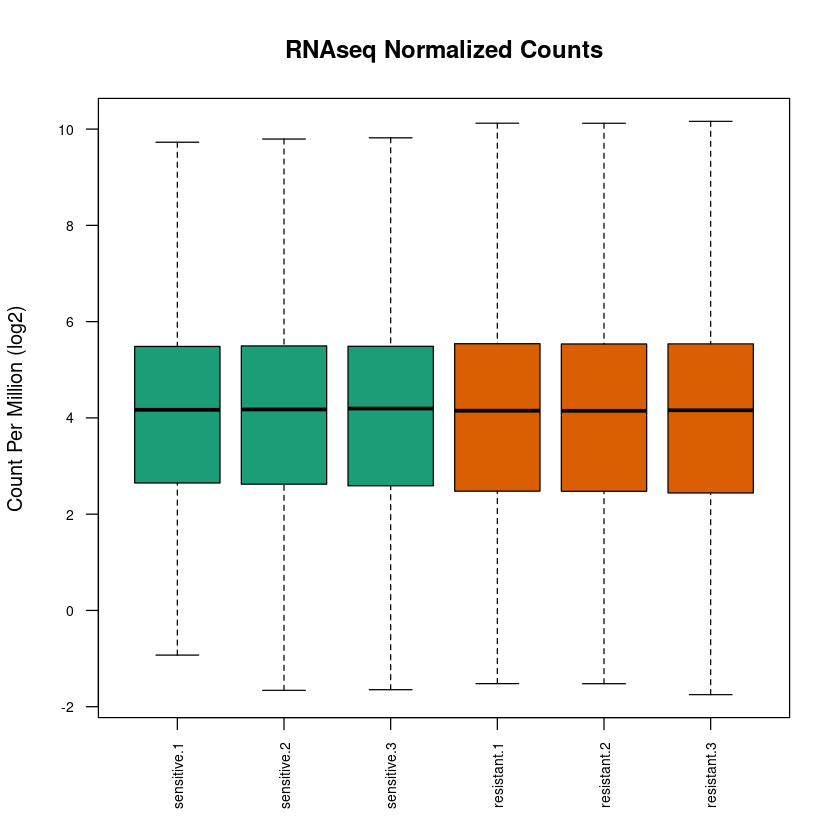

In [25]:
boxplot(log2(cpm_norm + 0.1), col=group_cols, las=2, outline=FALSE, names=pdata$sample.label, cex.axis=0.7, 
        main="RNAseq Normalized Counts", ylab="Count Per Million (log2)")

Despite the differences in the overall size of the libraries, they appear similar after normalization.  

The CPM values are a useful way to visualize RNA-seq data, but they do not account for the length of the transcripts.  This is one shortfall of RNA-seq over microarrays.  Expression of short genes is always at a disadvantage to expression of long genes because there is simply less RNA to sequence.  This is especially true if your RNA-seq analysis pipeline removes duplicate sequences.  

One thing that you can do is scale the CPM values accounting for the length of the genes.  Note, this IS NOT done for the actual differential expression analysis in **edgeR**.  It can be done to aid visualization and downstream functional analysis.

### Reads Per Kilobase Per Million
RPKM values can be used to compare relative expression levels of different genes.  Again, not generally on a statistical basis, but more for functional analysis.  To convert the CPM values to RPKM (Reads Per Kilobase Per Million), we need the length of the synthetic transcripts.  We can get this from the **GRangesList** that we made.  

In [26]:
#library(GenomicRanges, verbose=FALSE)
load("./data/GenesByExons.RData")

First, we use **width** to get the length of each exon.  

In [27]:
exon_lengths <- width(genesByExon_gr)
head(exon_lengths)

IntegerList of length 6
[["5S_rRNA"]] 126 110 119 106 119 119 115 87 120 119
[["5_8S_rRNA"]] 151 152 152 152 151 153 152 153 153
[["7SK"]] 250 250 250 244 331 298 247
[["A1BG"]] 1852 305 282 1165 270 36 89
[["A1BG-AS1"]] 127 1505 1742
[["A1CF"]] 7472 149 137 206 274 98 165 74 239 131 135 143 144 93 48 95

Now, we can **sum** the length of the exons for each transcript using **sapply** to work down the list.  

In [28]:
transcript_lengths <- sapply(exon_lengths, sum)
head(transcript_lengths)

5S_rRNA 5_8S_rRNA       7SK      A1BG  A1BG-AS1      A1CF 
     1140      1369      1870      3999      3374      9603

Now, we need to remove the same transcripts that we filtered from the **DGEList**.  

In [29]:
lengths_keep <- transcript_lengths[keep]
head(lengths_keep)

5_8S_rRNA  A1BG-AS1   A2M-AS1      AAAS      AACS     AADAT 
     1369      3374      2948      4727     16039      2970

We can confirm that the dimension and order of the transcript lengths is the same as the order of the transcripts in **cpm_norm**.

In [30]:
lengths_keep<-lengths_keep[names(lengths_keep) %in% rownames(my_dge$counts)]
length(lengths_keep)
dim(my_dge)

[1] 13644

[1] 13644     6

In [31]:

table(names(lengths_keep) == rownames(my_dge$counts))
head(names(lengths_keep)) # print first 6 names
head(rownames(my_dge$counts))


 TRUE 
13644 

[1] "5_8S_rRNA" "A1BG-AS1"  "A2M-AS1"   "AAAS"      "AACS"      "AADAT"

[1] "5_8S_rRNA" "A1BG-AS1"  "A2M-AS1"   "AAAS"      "AACS"      "AADAT"

In [32]:
rpkm_norm <- rpkm(my_dge, gene.length=lengths_keep, normalized.lib.sizes=TRUE, log=FALSE)
head(rpkm_norm)

,PDX4_TG_SE1,PDX4_TG_SE2,PDX4_TG_SE3,PDX4_TG_CR1,PDX4_TG_CR2,PDX4_TG_CR3
5_8S_rRNA,6234.5692012,5616.8241820,9701.1946546,1.009015e+04,9824.882061,6152.8618695
A1BG-AS1,2.2069006,1.7318798,1.4302792,1.252304e+00,1.618502,0.7601189
A2M-AS1,0.5773276,0.6607149,0.8184806,4.215495e-01,0.336797,0.6022798
AAAS,9.0912911,9.4772822,9.5592722,8.044738e+00,10.082107,8.0965384
AACS,1.2998959,1.2413939,1.2035069,9.762686e-01,1.392839,1.0947022
AADAT,3.8680948,5.5380416,4.8006508,5.690606e+00,6.268166,5.9781845


We are now ready to start the **edgeR** analysis.

## Making the Model Matrix

The next step in the analysis is to describe the experiment and analysis for **edgeR** in the form of a matrix. The matrix must have one row for every sample and one column for each of the experimental effects/groups that you want to compare.

What experimental effects should we compare? For this data, we have one control (BPH) and three treatment groups (CaP, advanced CaP and CRPC). We could specify a design to estimate each group's effect separately (as well as any interaction). This will allow us to specify pairwise contrasts later.

The `model.matrix` function makes this quite simple because it can pull the information from the pData. However, it is always a good idea to check your matrix.

In [33]:
my_design <- model.matrix(~ 0 + my_dge$samples$group)
rownames(my_design) <- rownames(my_dge$sample)
colnames(my_design) <- levels(my_dge$sample$group)
my_design

,sensitive,resistant
PDX4_TG_SE1,1,0
PDX4_TG_SE2,1,0
PDX4_TG_SE3,1,0
PDX4_TG_CR1,0,1
PDX4_TG_CR2,0,1
PDX4_TG_CR3,0,1


We are finally getting to the statistical analysis.

RNAseq data is based on counts and is discrete (integer values only). Because of the nature of the data, edgeR uses **exactTest** function to perform a test that is based on the negative binomial distribution. Earlier methods of RNAseq analysis used the Poisson distribution, but these methods have fallen out of favor because the Poisson distribution is not a good fit for RNAseq data.

## Estimate Dispersion

First, we need to estimate the dispersion in the gene counts.  The disperion is the variability in the data, sometimes from biological sources, but technical factors can also affect disperion.  Note that **edgeR** allows you to set a minimal expression threshold for the genes.  We have already filtered our data, so I set this to zero.  

In [34]:
#library(statmod, verbose=FALSE)
my_dge <- estimateDisp(my_dge, design=my_design, min.row.sum=0, robust=TRUE)

Now, we can plot the dispersion.  Three values are shown:
* **Tagwise** - The actual dispresion of each individual gene.
* **Common** - The estimate for all genes.
* **Trended** - Takes into account the value of the counts, i.e. low expressing gene often have high disperion.

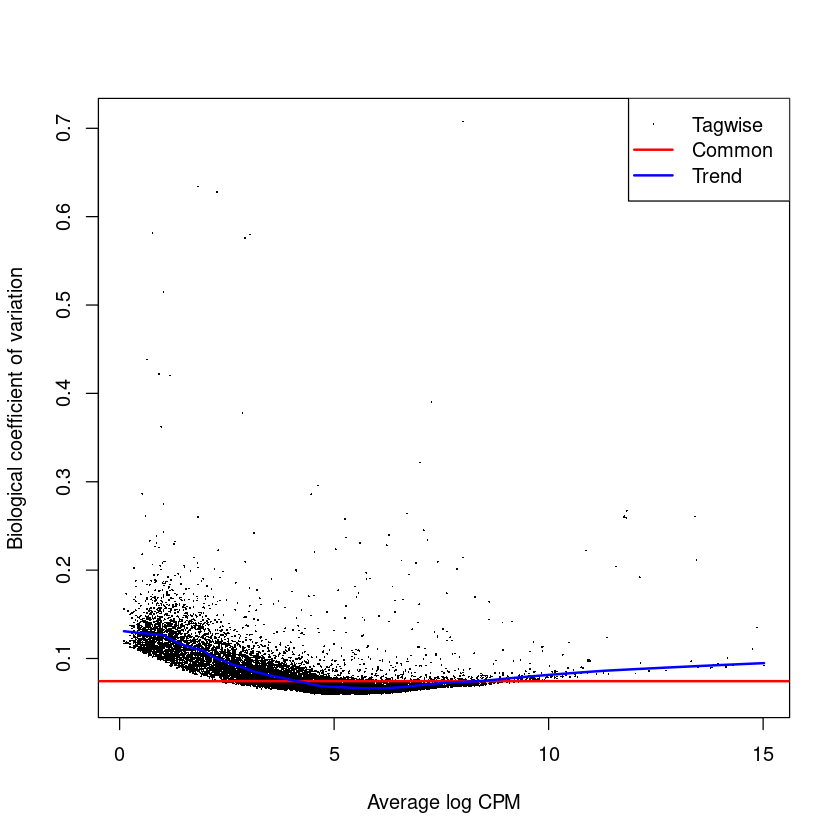

In [35]:
plotBCV(my_dge)

### MDS Plots to Assess Replicates

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



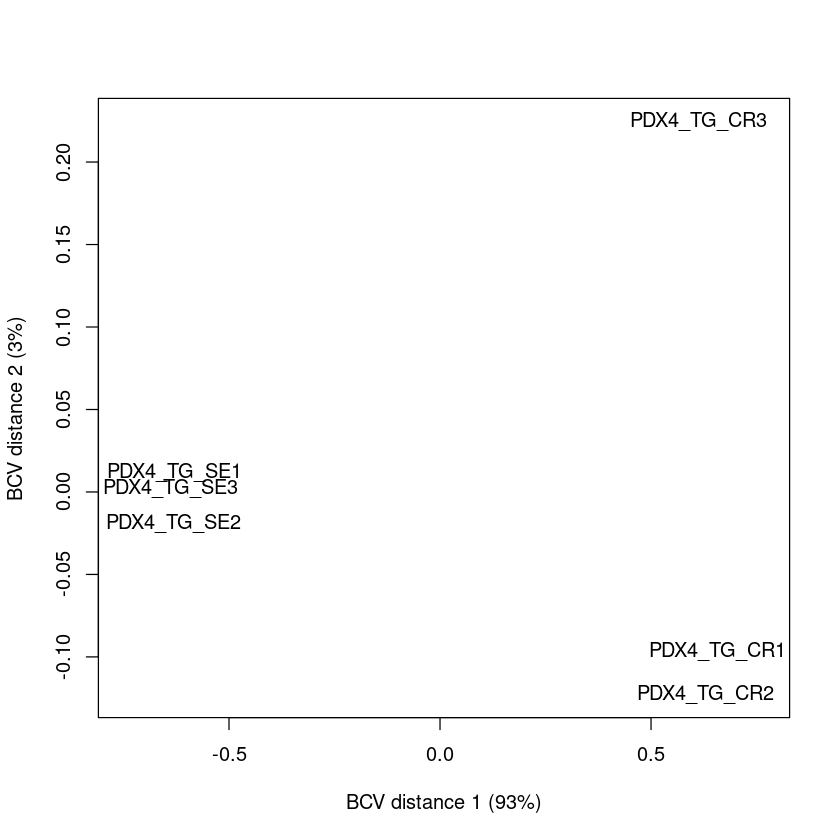

In [36]:
plotMDS(my_dge, method="bcv", top=500)

We can add group labels and color the samples by group.

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



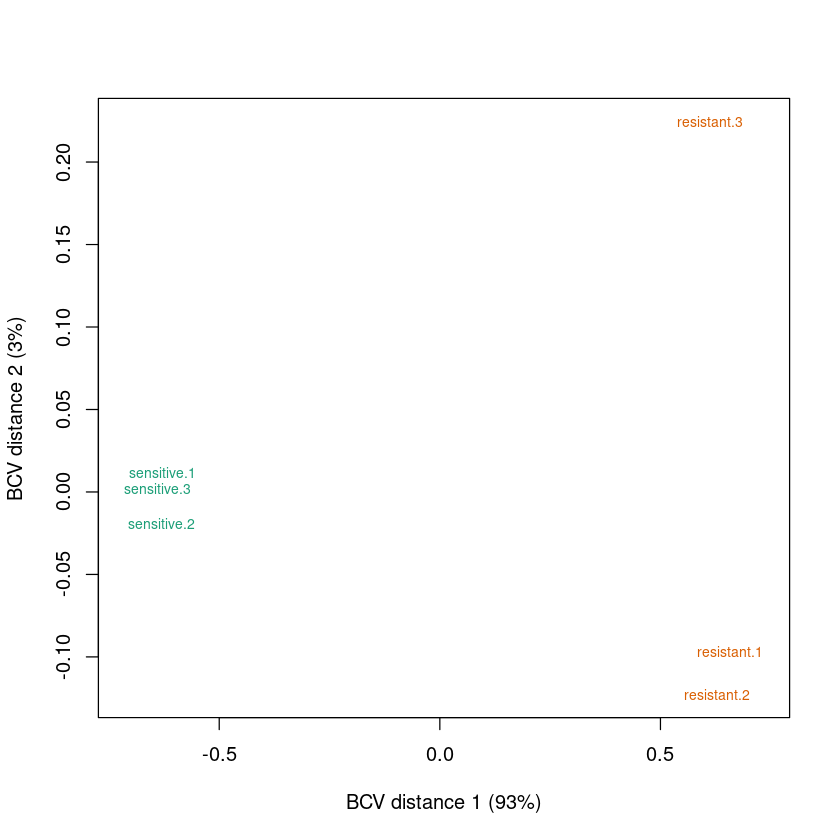

In [37]:
plotMDS(my_dge, method="bcv", top=500, labels=as.factor(my_dge$samples$sample.label), cex=0.7, col=group_cols)

The BCV MDS plot shows that there is good agreement between biological replicates in control and CaP. But the agreement in CRPC and advanced CaP is not so satifying. There also appears to be a clear experiment effect for the knockdowns. We can confirm with a similar plot that uses log fold change (logFC).

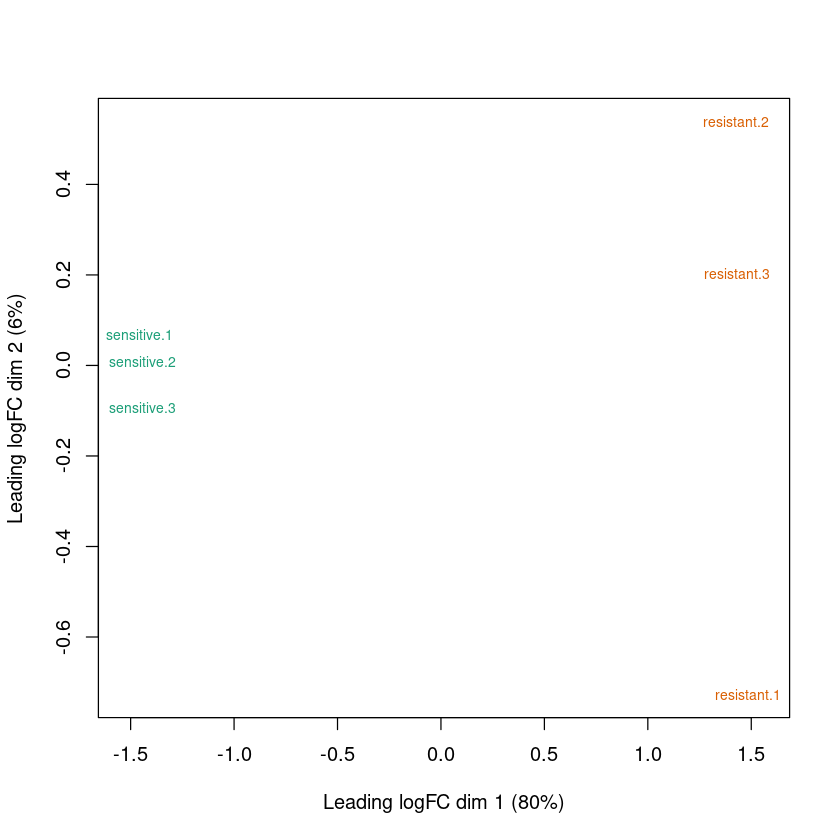

In [38]:
plotMDS(my_dge, method="logFC", top=500, labels=my_dge$samples$sample.label, cex=0.7, col=group_cols)

The logFC MDS plot also shows a similar result.

### Hierarchical Clustering
We can confirm the MDS plots by hierarchical clustering.  

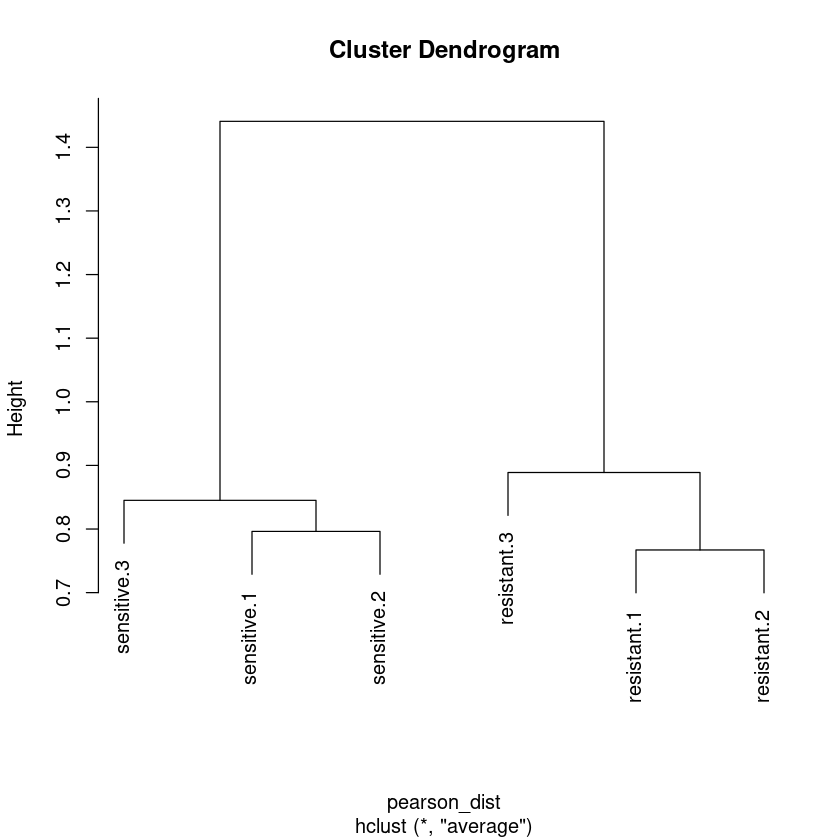

In [39]:
rpkm_mean <- rowMeans(rpkm_norm)
rpkm_sd <- apply(rpkm_norm, 1, sd)
rpkm_zscores <- sweep(rpkm_norm, 1, rpkm_mean, "-")
rpkm_zscores <- sweep(rpkm_zscores, 1, rpkm_sd, "/")
pearson_dist <- cor(rpkm_zscores, method="pearson", use="everything")
pearson_dist <- as.dist(1 - pearson_dist)
my_hclust <- hclust(pearson_dist, "average")
my_hclust$labels <- pdata$sample.label
plot(my_hclust)

The two groups "CRPC" and "advanced CaP" are more similar to each other than to the control.  That is an important point.  

In [40]:
save(my_dge,file="./data/my_dge_paired.RData")

## Perform Statistical Tests

### exactTest
There are various methods in **edgeR** to compare groups.  Here, we will use the **exactTest** that will do direct comparisons of the counts for two groups.  This method performs well in benchmarking tests of **edgeR**, see [Schurch, et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4878611/) and is suitable for this experiment.  Again, I recommend that you keep the default arguments unless you have good reason to change them.

The **pair** argument specifies the groups that you want to compare.  Our first group is **BPH** and the 4th is **CRPC**, so **pair=c(1, 4)** is **CRPC / BPH**.

In [41]:
resistant_et <- exactTest(my_dge, pair=1:2, dispersion="auto", rejection.region="deviance",
                     big.count=900, prior.count=0.125)
# the options shown here are alll default values

### topTags
Similar to limma, the **topTags** function will summarize the tests.  I always select all genes and do not sort.  The resulting object is a list with multiple elements, including a table of results. The **logFC** is the log2 ratio of the change between the two groups. And **FDR** is the p-value after adjusting for multiple testing. We use benjamini-hochberg procedure ("BH") for adjustment.

In [42]:
resistant_tt <- topTags(resistant_et, n=nrow(my_dge), sort.by="none")
head(resistant_tt)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
5_8S_rRNA,0.2744045,13.407425,0.37290067,0.5667658
A1BG-AS1,-0.5987457,2.455452,0.05580992,0.1422512
A2M-AS1,-0.5497029,1.102261,0.25098012,0.4335198
AAAS,-0.1054660,5.433895,0.38308565,0.5770391
AACS,-0.1167936,4.300692,0.46531182,0.6545741
AADAT,0.3369653,4.027755,0.04320388,0.1171728


### decideTests
The **decideTestsDGE** will produce a vector of gene calls based on your specified cutoffs. We use the option `p.value` to specify the cut-off at 0.05. `lfc` is the minimum absolute log2 fold change required, so I just keep the default of 0.

The result is a table of either 0,1 or -1 for each genes, where **0** indicates no significant change between groups, **1** indicates a positive change or upregulated from control to treatment, and **-1** indicates a negative change or downregulated in expression.

In [43]:
resistant_tests <- decideTestsDGE(resistant_et, adjust.method="BH", p.value=0.05, lfc=0)
head(resistant_tests)

,resistant-sensitive
5_8S_rRNA,0
A1BG-AS1,0
A2M-AS1,0
AAAS,0
AACS,0
AADAT,0


We can summarize the differentially expressed genes (DEGs) with **table** to check how many differential genes we have. 

In [44]:
table(resistant_tests)

resistant_tests
  -1    0    1 
2061 9623 1960 

This table shows that we got 15966 insignificant genes, 764 genes with upregulated effects in CRPC and 1276 genes with downregulated effects in CRPC.

### Practice:

We performed an Exact test on only one pair of groups, 'BPH' and 'CRPC' group. Repeat the above exact test using another pair of groups. Note that the first level will be used as a control group. Summarize the test results with `topTags` and `decideTestsDGE` function. How many differentially expressed genes (DGEs) do you have for your selected groups?

In [45]:
# write your codes here



**Write down which groups you selected, and summarize how many DGEs did you get? (Double click to enable editing.)**




## Visualizing the Results

There are several ways to visually summarize the results of your experiment.  A smear plot shows the relationship between gene counts and log fold-change.  Differentially expressed genes can be highlighted. Each point is a gene and significant genes are highlighted in red.

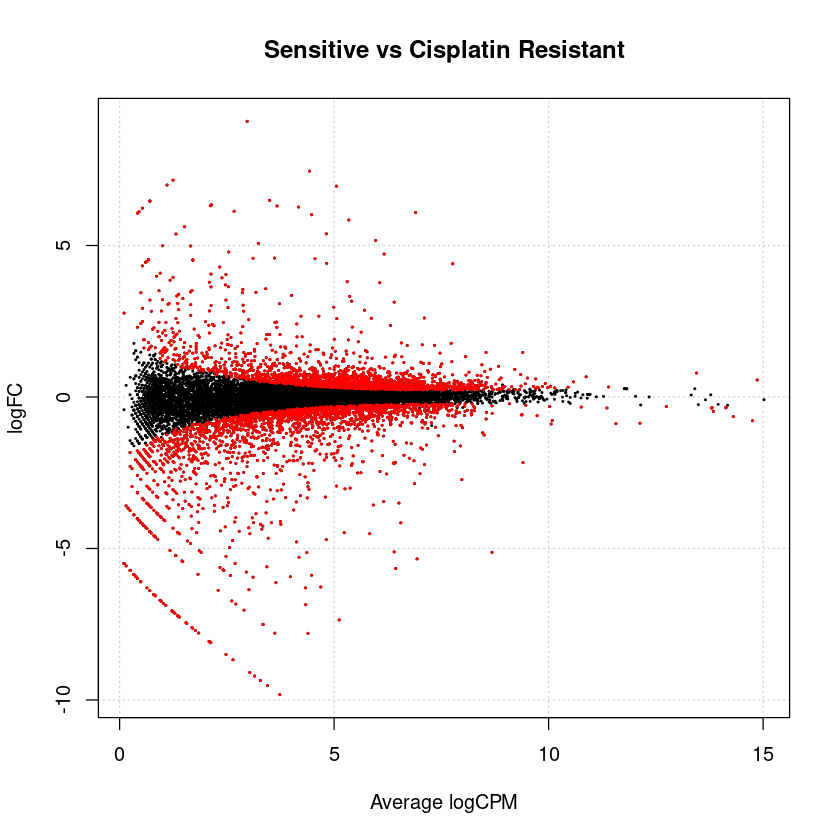

In [46]:
plotSmear(resistant_et, de.tags=rownames(resistant_tt)[resistant_tests != 0], main="Sensitive vs Cisplatin Resistant")

It should not be surprising that genes with high average counts can have only modest log fold-changes, but still be considered statistically significant.  As a researcher, you must decide if you want to set a log fold-change cutoff.  

### Volcano Plots
Volcano plots visualize the relationship between FDR (-log10) and log2 fold-change. Still, each point is a gene. Genes with significant positive effect is highlighted in red while genes with negative effect is highlighted in blue.

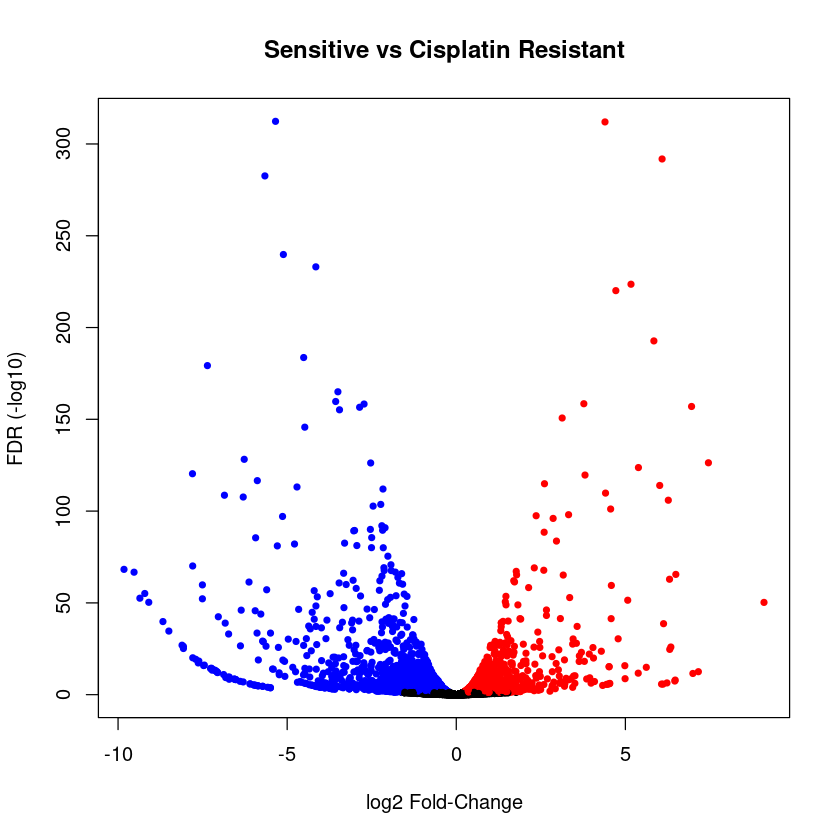

In [47]:
plot(resistant_tt$table$logFC, -log10(resistant_tt$table$FDR), 
     col=c("blue", "black", "red")[as.factor(resistant_tests)], ylab="FDR (-log10)", 
     xlab="log2 Fold-Change", main="Sensitive vs Cisplatin Resistant", pch=20)

### Corrplots 
Correlation plots can be used to demonstrate consistency between your replicates.  Here we will do them only using the data for the DEGs. 

In [48]:
degs <- rownames(resistant_tests)[resistant_tests != 0]
head(degs)

[1] "AAGAB"    "AAMP"     "AARD"     "AARS1"    "AARS2"    "AASDHPPT"

We can plot the correlation matrix between each sample using the corrplot Package.

In [49]:
degs_zscores <- rpkm_zscores[degs, ]
colnames(degs_zscores) <- my_dge$samples$sample.label
head(degs_zscores)

,sensitive.1,sensitive.2,sensitive.3,resistant.1,resistant.2,resistant.3
AAGAB,0.9897065,1.4781158,-0.2302198,-0.62951083,-1.0201368,-0.5879548
AAMP,-0.2545887,-1.1022959,-1.0253020,1.40704421,0.1607231,0.8144193
AARD,0.7472893,0.8485573,1.1217199,-0.88960277,-0.8901632,-0.9378006
AARS1,0.9138645,0.8886553,0.8343722,-0.41021552,-0.9875495,-1.2391270
AARS2,0.8124952,0.3411907,1.1757534,0.01170869,-1.3946497,-0.9464984
AASDHPPT,-0.5731964,-1.1135899,-0.9036343,0.83516172,1.3117070,0.4435518


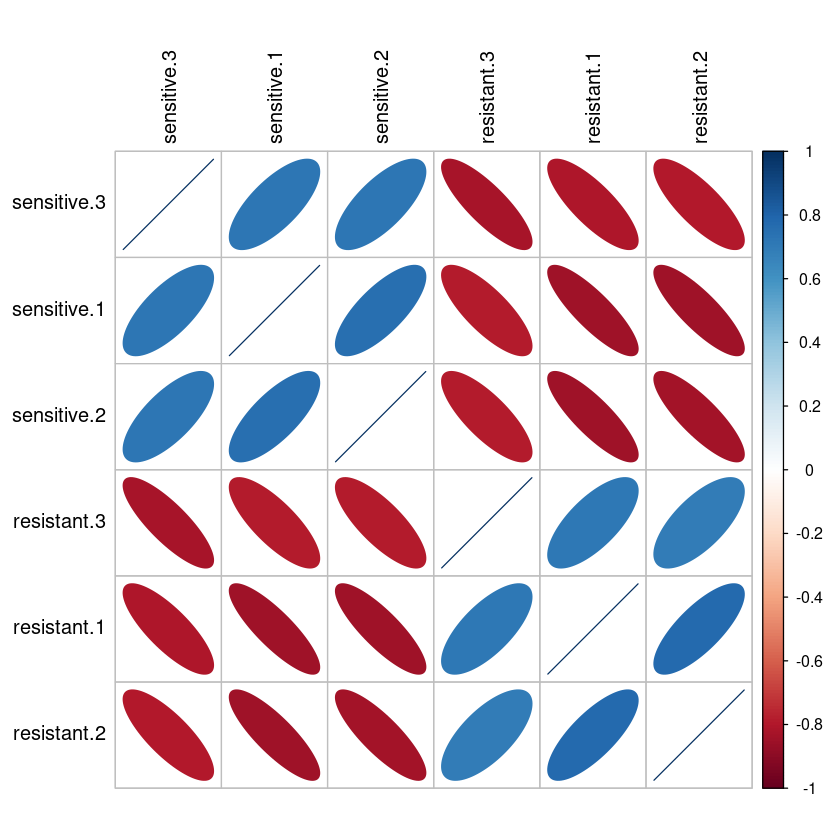

In [50]:
# library(corrplot)
my_cor <- cor(degs_zscores, method="pearson")
corrplot(my_cor, method="ellipse", order="hclust", hclust.method="average", tl.col="black")

### Heatmaps
We can further examine the consistency between biological replicates with a heat map for the DEGs.  There is an R package called **pheatmap** (pretty heatmaps) that take much of the work out of this task. 

In [51]:
library(pheatmap)

Make a topTable for only the DEGs, and sort it by increasing FDR.

In [52]:
dge_tt <- resistant_tt$table[degs, ]
dge_tt <- dge_tt[order(dge_tt$FDR, decreasing=FALSE), ]
head(dge_tt)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
COL11A1,-5.126327,8.679735,0.000000e+00,0.000000e+00
GJA1,-5.344270,6.933351,6.929499e-317,4.727305e-313
GCLC,4.397147,7.764801,2.186256e-316,9.943094e-313
COL16A1,6.085415,6.899039,4.448527e-296,1.517393e-292
TMEM30B,-5.658520,6.435527,9.418812e-287,2.570205e-283
SPRY1,-5.112124,6.400379,7.348174e-244,1.670975e-240


Get the gene symbols for the top 50 DEGs to use as an index for the zscores.  Fifty is a reasonable number if you want to see the gene labels.

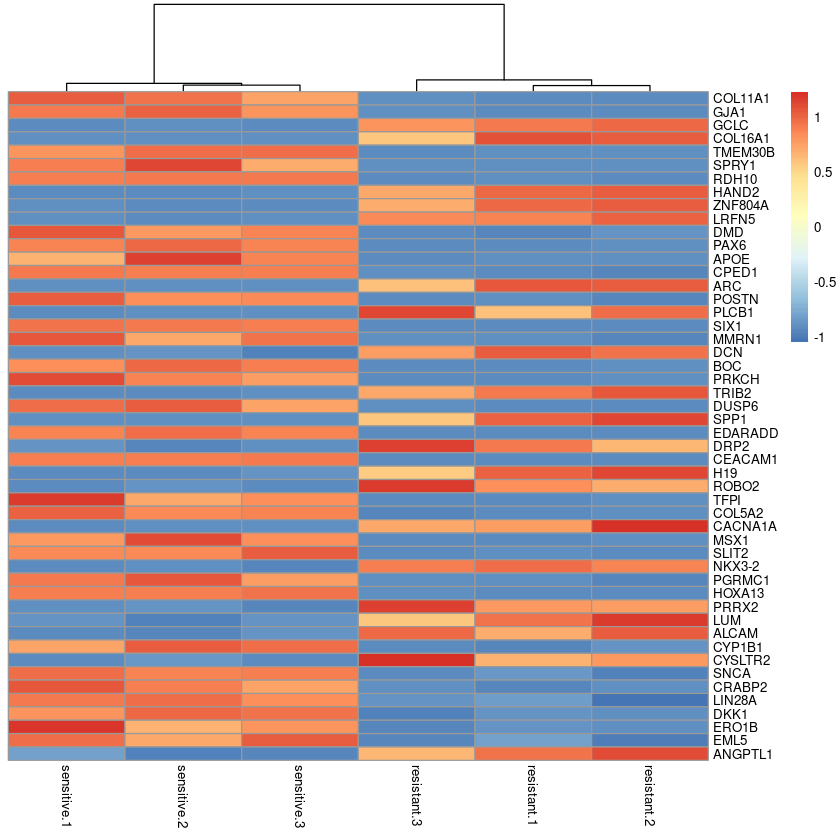

In [53]:
gene_no <- 50
my_top <- rownames(dge_tt)[1:gene_no]
top_zscores <- rpkm_zscores[my_top, ]
colnames(top_zscores) <- my_dge$samples$sample.label
pheatmap(top_zscores, cluster_col=TRUE, cluster_rows=FALSE, clustering_distance_cols="euclidean", 
        cluster_method="average",fontsize=8)

The samples seem to be quite consistent.  There is little chance that samples were swapped.  Note, the gene list is sorted based on differential expression in the CRPC knockdown.  These genes will not necessarily be affected by the knockdown of others.

### Boxplots for Individual Genes

We can check the expression of the primary genes that stated by the authors to be associated with progression of CRPC. There is a large difference in expression level among the groups.

In [85]:
my_gene <- ""
boxplot(rpkm_norm[my_gene, ] ~ my_dge$sample$group, col=group_pal, main=my_gene, ylab="RPKM", 
        xlab="Treatment")
stripchart(rpkm_norm[my_gene, ] ~ my_dge$sample$group, vertical=TRUE, method="jitter", jitter=0.1, 
          add=TRUE, pch=1)

ERROR: Error in rpkm_norm[my_gene, ]: subscript out of bounds


We can also check SP8 and AR. 

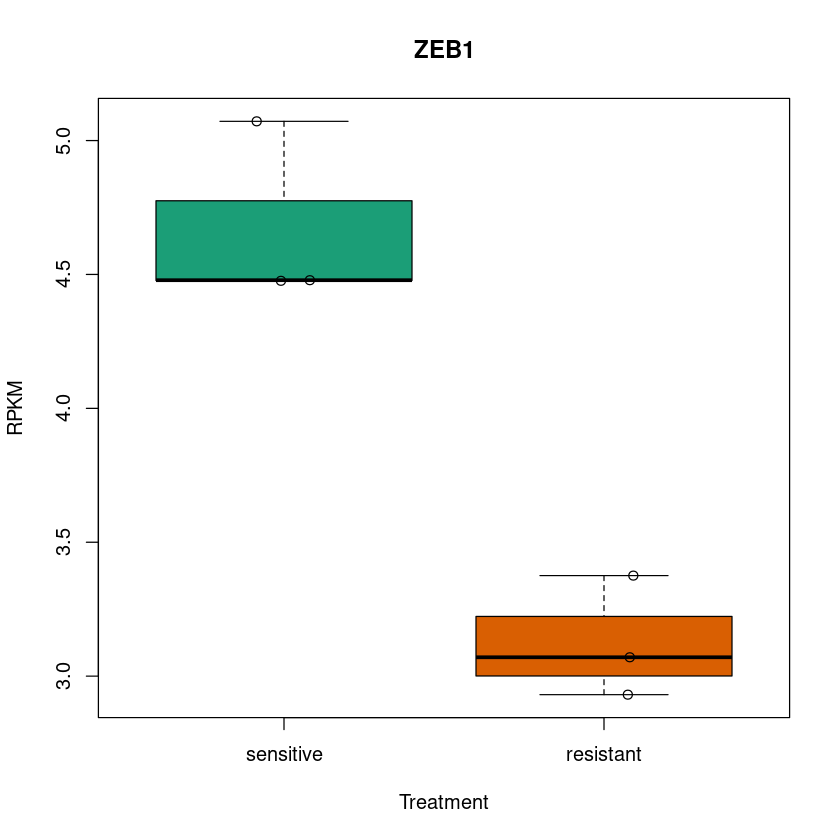

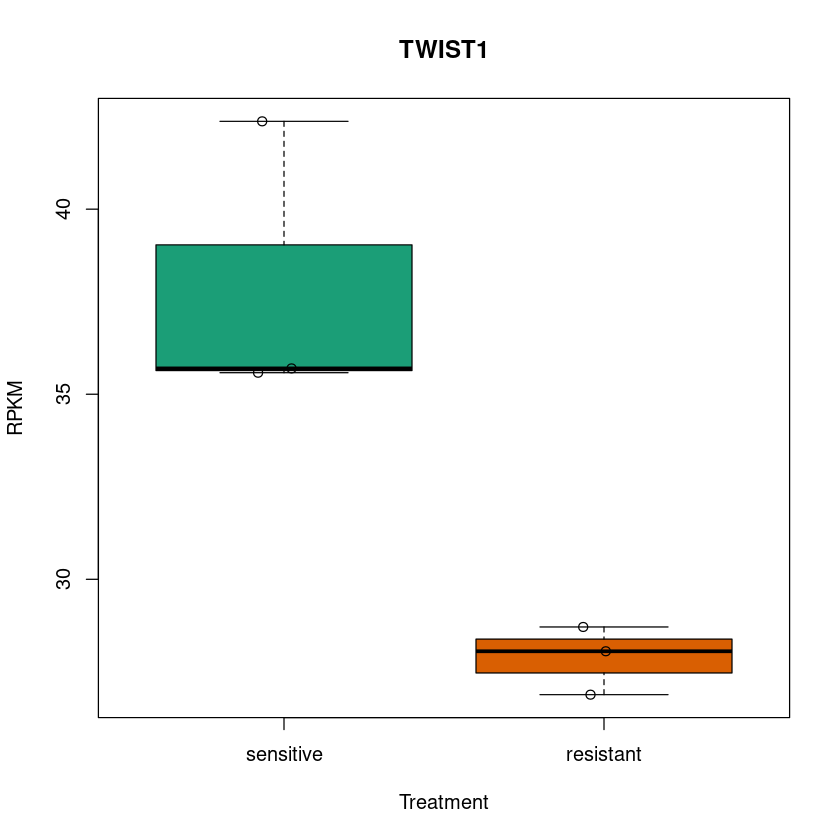

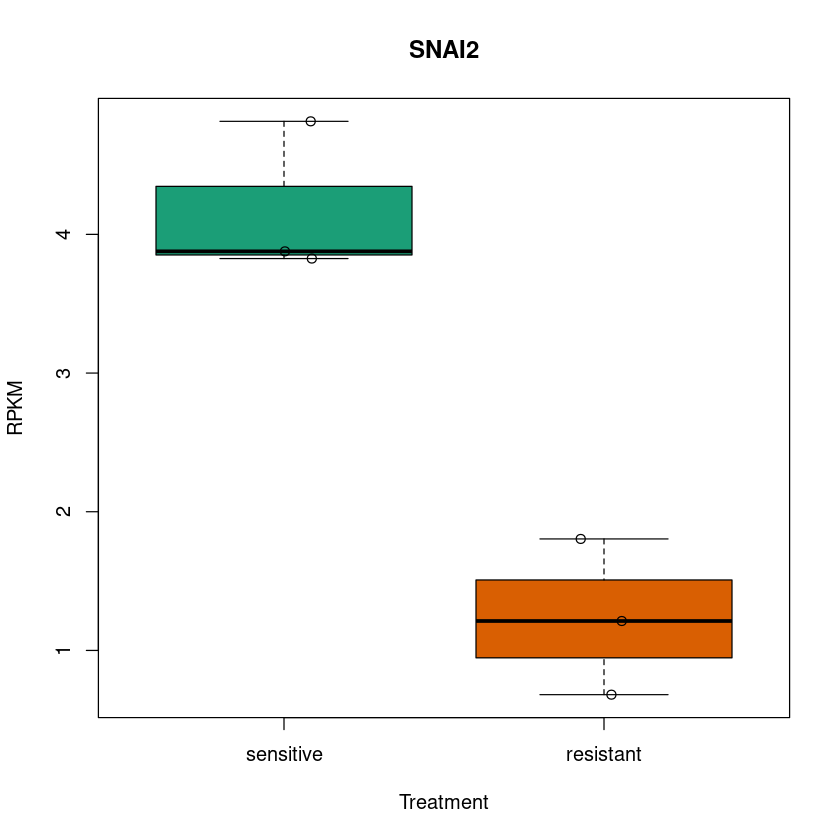

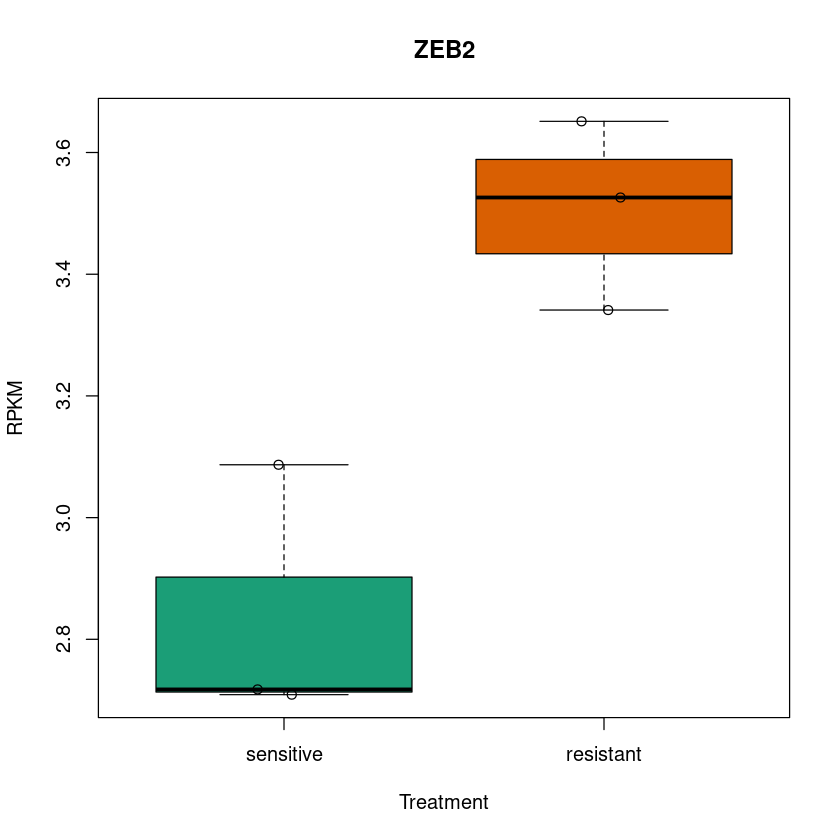

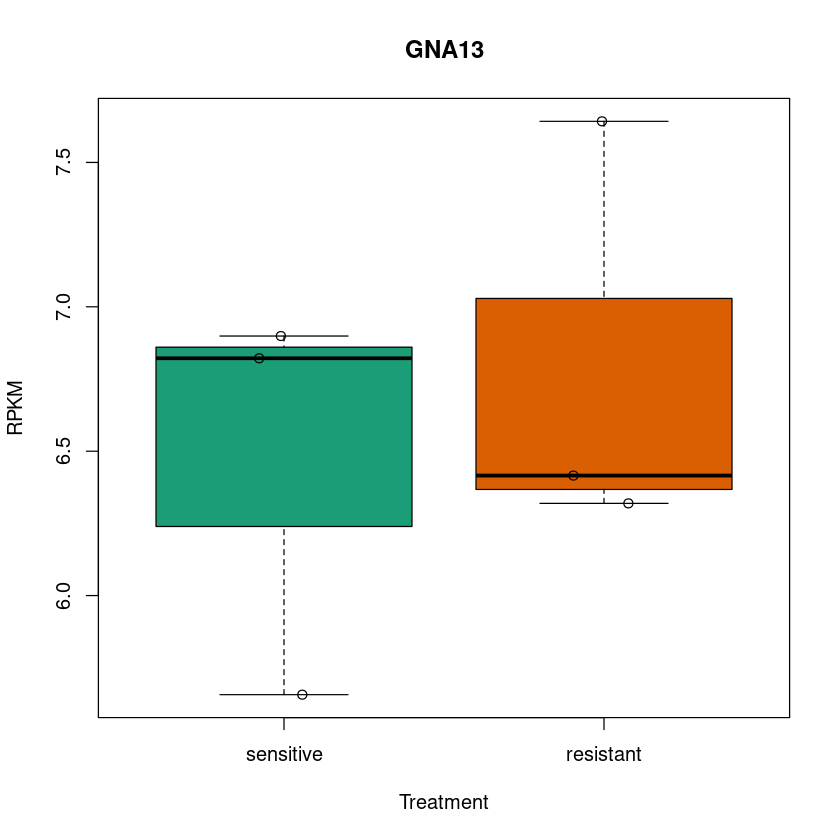

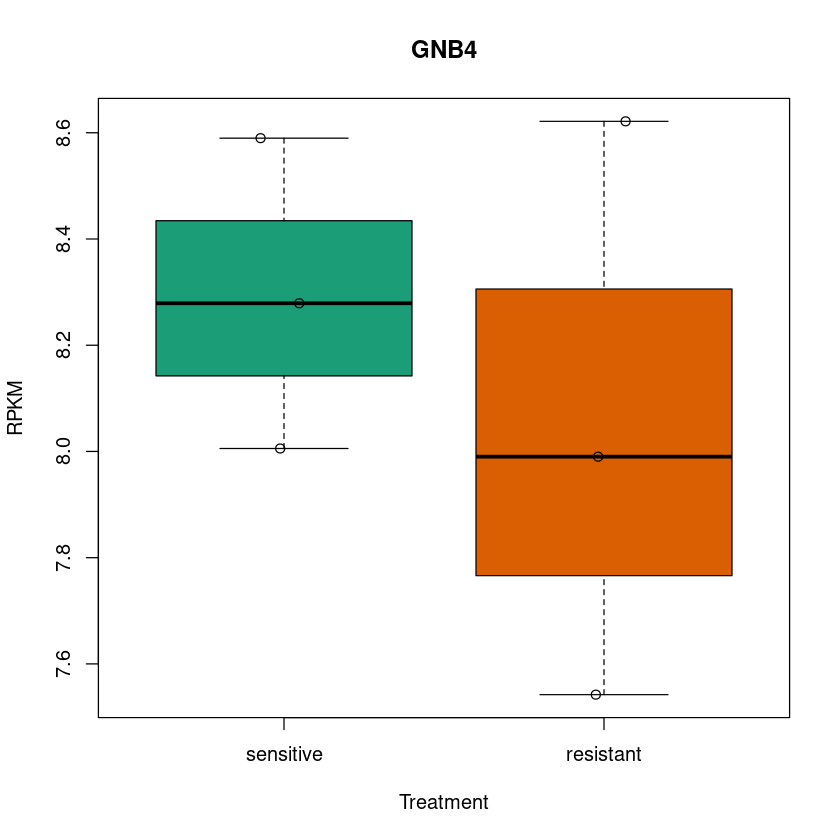

In [55]:
my_gene <- "ZEB1"
boxplot(rpkm_norm[my_gene, ] ~ my_dge$sample$group, col=group_pal, main=my_gene, ylab="RPKM", 
        xlab="Treatment")
stripchart(rpkm_norm[my_gene, ] ~ my_dge$sample$group, vertical=TRUE, method="jitter", jitter=0.1, 
          add=TRUE, pch=1)

my_gene <- "TWIST1"
boxplot(rpkm_norm[my_gene, ] ~ my_dge$sample$group, col=group_pal, main=my_gene, ylab="RPKM", 
        xlab="Treatment")
stripchart(rpkm_norm[my_gene, ] ~ my_dge$sample$group, vertical=TRUE, method="jitter", jitter=0.1, 
          add=TRUE, pch=1)

my_gene <- "SNAI2"
boxplot(rpkm_norm[my_gene, ] ~ my_dge$sample$group, col=group_pal, main=my_gene, ylab="RPKM", 
        xlab="Treatment")
stripchart(rpkm_norm[my_gene, ] ~ my_dge$sample$group, vertical=TRUE, method="jitter", jitter=0.1, 
          add=TRUE, pch=1)

my_gene <- "ZEB2"
boxplot(rpkm_norm[my_gene, ] ~ my_dge$sample$group, col=group_pal, main=my_gene, ylab="RPKM", 
        xlab="Treatment")
stripchart(rpkm_norm[my_gene, ] ~ my_dge$sample$group, vertical=TRUE, method="jitter", jitter=0.1, 
          add=TRUE, pch=1)

my_gene <- "GNA13"
boxplot(rpkm_norm[my_gene, ] ~ my_dge$sample$group, col=group_pal, main=my_gene, ylab="RPKM", 
        xlab="Treatment")
stripchart(rpkm_norm[my_gene, ] ~ my_dge$sample$group, vertical=TRUE, method="jitter", jitter=0.1, 
          add=TRUE, pch=1)

my_gene <- "GNB4"
boxplot(rpkm_norm[my_gene, ] ~ my_dge$sample$group, col=group_pal, main=my_gene, ylab="RPKM", 
        xlab="Treatment")
stripchart(rpkm_norm[my_gene, ] ~ my_dge$sample$group, vertical=TRUE, method="jitter", jitter=0.1, 
          add=TRUE, pch=1)

[Yun, et al., Oncotarget., 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5777737/) claimed that 12 genes are associated with progression into CRPC, we can visualize these genes in a heatmap.

To avoid data entry error, I copy and pasted the gene list into my R code.  However, I need to convert this long **character string** to a **character vector** of gene symbols, removing the commas in the process.   If you ever attempt something similar, watch for hidden formatting characters such as **tabs** or **end-of-line**.

In [56]:
resistance_up <- "SLC22A2,SLC47A1,SLC31A1,ATP7A,ATP7B,ABCC2,ABCC4"
resistance_up <- c(strsplit(resistance_up, split=", ")[[1]], recursive=TRUE)
print(resistance_up)

[1] "SLC22A2,SLC47A1,SLC31A1,ATP7A,ATP7B,ABCC2,ABCC4"


Same for the putative down-regulated genes.  

In [57]:
resistance_down <- "KEAP1,XPA,XPC,RAD23B,RPA2"
resistance_down <- c(strsplit(resistance_down, split=", ")[[1]], recursive=TRUE)
resistance_down

[1] "KEAP1,XPA,XPC,RAD23B,RPA2"

Now, we need to select only those genes that we have been able to examine in the RNA-seq experiment, i.e. we need to remove genes that were filtered.  

In [58]:
resistance_up <- intersect(resistance_up, rownames(rpkm_zscores))
resistance_down <- intersect(resistance_down, rownames(rpkm_zscores))

In [80]:
resistance_all <- union(resistance_up, resistance_down)
resistance_zscores <- rpkm_zscores[resistance_all, ]
colnames(resistance_zscores) <- my_dge$samples$sample.label
pheatmap(resistance_zscores, cluster_col=TRUE, cluster_rows=TRUE, clustering_distance_cols="euclidean", 
        cluster_method="average")

ERROR: Error in hclust(d, method = method): must have n >= 2 objects to cluster


# Saving the Results

A critical step of bioinformatics analysis is to carefully document all steps.  This task is often ignored and publications frequently have inadequate documentation of data processing and analysis.  This is one advantage of tools like Jupyter Notebooks or Rmarkdown (not covered in this course).  The workflow from the RNA-seq Notebooks should be saved downloaded in at least two formats, HTML and R are recommended.  

In addition, we will save the result to a tab-delimited text file that can be imported into Microsoft Excel or LibreOffice Calc.  First, let's assemble the **edgeR** results in a single file.  

In [59]:
#library(data.table)
resistant_results <- resistant_tt$table
# crpc_results<- data.table(crpc_results)
resistant_results$test <- as.vector(resistant_tests)
resistant_results$SYMBOL <- rownames(resistant_results)
head(resistant_results)

,logFC,logCPM,PValue,FDR,test,SYMBOL
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
5_8S_rRNA,0.2744045,13.407425,0.37290067,0.5667658,0,5_8S_rRNA
A1BG-AS1,-0.5987457,2.455452,0.05580992,0.1422512,0,A1BG-AS1
A2M-AS1,-0.5497029,1.102261,0.25098012,0.4335198,0,A2M-AS1
AAAS,-0.1054660,5.433895,0.38308565,0.5770391,0,AAAS
AACS,-0.1167936,4.300692,0.46531182,0.6545741,0,AACS
AADAT,0.3369653,4.027755,0.04320388,0.1171728,0,AADAT


## Gene Annotations

We have the **edgeR** results for our genes, but we only have the gene symbol.  It may be helpful to other gene identifiers.  We could use a **Bioconductor** database as we did previously.  This time, we are going to use a file from [Human Genome Nomenclature Committee website](https://www.genenames.org/cgi-bin/download).  

In [60]:
hgnc_genes <- read.delim("/anvil/projects/x-tra220018/2022/course/unit1/1a_bulkRNAseq/data/HGNC_genes.txt", sep="\t", as.is=TRUE, header=TRUE)
head(hgnc_genes)

,HGNC.ID,Approved.Symbol,Approved.Name,Status,Previous.Symbols,Synonyms,Chromosome,Accession.Numbers,Entrez.Gene.ID,RefSeq.IDs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,HGNC:5,A1BG,alpha-1-B glycoprotein,Approved,,,19q13.43,,1,NM_130786
2,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,503538,NR_015380
3,HGNC:24086,A1CF,APOBEC1 complementation factor,Approved,,"ACF, ASP, ACF64, ACF65, APOBEC1CF",10q11.23,AF271790,29974,NM_014576
4,HGNC:7,A2M,alpha-2-macroglobulin,Approved,,"FWP007, S863-7, CPAMD5",12p13.31,"BX647329, X68728, M11313",2,NM_000014
5,HGNC:27057,A2M-AS1,A2M antisense RNA 1 (head to head),Approved,,,12p13.31,,144571,NR_026971
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,Approved,CPAMD9,"FLJ25179, p170",12p13.31,AK057908,144568,NM_144670


Let's see if we can map the symbols in our results to **Approved.Symbol**.  

In [61]:
table(resistant_results$SYMBOL %in% hgnc_genes$Approved.Symbol)


FALSE  TRUE 
  616 13028 

Seems like we are OK for most of our symbols.  This does raise a concern though.  We cannot be sure that we have the current HGNC approved symbol.  Therefore, we need to search all possible fields in this file, **Approved.Symbol**, **Previous.Symbols** and **Synonyms**.  We can use **grep** for this, but we need to be careful.  

We cannot search with exact matching because there can be multiple symbols in each column.  A simple pattern search with **grep** will also be a problem because of partial matches.  To control for this, we need to use an actual **regular expression** to allow for only specific characters after our gene symbol.

For example, *C6orf1* will produce a partial match to any columns that contain this character string such as *C6orf12* or *C6orf100*.  We cannot force an exact match because there could be more than one **Previous.Symbol**, so we need to allow for possibilities like *C6orf1,XXX* or *XXX,C6orf1* where *XXX* is another **Previous.Symbol**.  

To do this, we are going to add two possibilities to the end of the symbol pattern.  First, we want no characters to precede or follow the gene symbol, i.e. it is the only symbol in the column.  We can indicate the start of the string with a carat, `^`, and the end of a string with a dollar sign, `$`, in our pattern.  Second, we will allow for a comma that is used to separate multiple symbols.  So, for any pattern, `XXX`, we will allow the following.
* `^XXX$` -- *C6orf1*
* `^XXX,` -- *C6orf1,* 
* `,XXX$` -- *,C6orf1*
* `,XXX,` -- *,C6orf1,*

We are also going to allow for leading or trailing spaces.  The R coding for these steps are complicated.  Do not worry about that.  The important point here is that it can be difficult to pull textual data from files or databases, especially when there are inconsistencies in data entry.  Many web tools do this for you.  However, I have always had concerns about accuracy.  

Dealing with gene identifiers is always frustrating.  This time, it is a bit more complicated because we are dealing with an earlier version of the human genome.

Please Note, the steps below are slow and will take about two minutes.  

In [62]:
approved <- lapply(resistant_results$SYMBOL, function(x)(grepl(paste("(^|,| +)", x, "($|,| +)", sep=""), hgnc_genes$Approved.Symbol, fixed=FALSE)))
names(approved) <- resistant_results$SYMBOL

Each element of **approved** is a **logical vector** that we sum to determine the number of hits.  

In [63]:
table(sapply(approved, sum))


    0     1 
  616 13028 

The number doesn't change. So we had over 17,000 hits and each is unique.  Now we can reformat the data. The column **Result.Symbol** is added in the process.  This is the symbol that we used in the gene count matrix.  

In [64]:
approved_data <- lapply(approved, function(x)(hgnc_genes[x, ]))
approved_data <- do.call(rbind, approved_data)
approved_data$Result.Symbol <- rownames(approved_data)
head(approved_data)

,HGNC.ID,Approved.Symbol,Approved.Name,Status,Previous.Symbols,Synonyms,Chromosome,Accession.Numbers,Entrez.Gene.ID,RefSeq.IDs,Result.Symbol
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
A1BG-AS1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,503538,NR_015380,A1BG-AS1
A2M-AS1,HGNC:27057,A2M-AS1,A2M antisense RNA 1 (head to head),Approved,,,12p13.31,,144571,NR_026971,A2M-AS1
AAAS,HGNC:13666,AAAS,aladin WD repeat nucleoporin,Approved,,,12q13.13,AJ289841,8086,,AAAS
AACS,HGNC:21298,AACS,acetoacetyl-CoA synthetase,Approved,,"FLJ12389, SUR-5, ACSF1",12q24.31,AK022451,65985,NM_023928,AACS
AADAT,HGNC:17929,AADAT,aminoadipate aminotransferase,Approved,,"KATII, KAT2, KYAT2",4q33,AF097994,51166,NM_016228,AADAT
AAGAB,HGNC:25662,AAGAB,alpha and gamma adaptin binding protein,Approved,,"FLJ11506, p34",15q23,AL136715,79719,NM_024666,AAGAB


Now we can search **Previous.Symbol**. This step is slow and takes about 2 minutes. 

In [65]:
previous_sym <- lapply(resistant_results$SYMBOL, function(x)(grepl(paste("(^|,| +)", x, "($|,| +)", sep=""), hgnc_genes$Previous.Symbols, fixed=FALSE)))
names(previous_sym) <- resistant_results$SYMBOL

In [66]:
table(sapply(previous_sym, sum))


    0     1     2     3 
13579    63     1     1 

We have two genes with more than one hit.   

In [67]:
which(sapply(previous_sym, sum)  > 1)

NET1 TRNP1 
 7254 12208

In [68]:
previous_data <- lapply(previous_sym, function(x)(hgnc_genes[x, ]))
previous_data <- do.call(rbind, previous_data)
previous_data$Result.Symbol <- rownames(previous_data)

In [69]:
head(previous_data)

,HGNC.ID,Approved.Symbol,Approved.Name,Status,Previous.Symbols,Synonyms,Chromosome,Accession.Numbers,Entrez.Gene.ID,RefSeq.IDs,Result.Symbol
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
ADCY3,HGNC:239,ADCY8,adenylate cyclase 8,Approved,ADCY3,"HBAC1, AC8",8q24.22,Z35309,114,,ADCY3
AK3,HGNC:363,AK4,adenylate kinase 4,Approved,"AK3, AK3L1",,1p31.3,AK025926,205,NM_013410,AK3
AK6,HGNC:17376,AK3,adenylate kinase 3,Approved,"AK6, AK3L1",AKL3L1,9p24.1,BC013771,50808,NM_016282,AK6
APPL2,HGNC:598,APLP2,amyloid beta precursor like protein 2,Approved,APPL2,APPH,11q24.3,L19597,334,NM_001642,APPL2
ARFGAP1,HGNC:661,ARFGAP3,ADP ribosylation factor GTPase activating protein 3,Approved,ARFGAP1,,22q13.2,AK002083,26286,NM_014570,ARFGAP1
BRF1,HGNC:1107,ZFP36L1,ZFP36 ring finger protein like 1,Approved,BRF1,"RNF162B, Berg36, ERF1, TIS11B, cMG1",14q24.1,X79066,677,,BRF1


Now, search the **Synonyms** column. This step also takes about 2 minutes.

In [70]:
synonym <- lapply(resistant_results$SYMBOL, function(x)(grepl(paste("(^|,| +)", x, "($|,| +)", sep=""), hgnc_genes$Synonyms, fixed=FALSE)))
names(synonym) <- resistant_results$SYMBOL

In [71]:
which(sapply(synonym, sum) > 1)

APC2   ATR  BAP1   CAD  CAST  CHD5   DAP   DBP   EBP  FHL1  GOT1   HGF   HK1 
  562   919  1001  1426  1510  1981  2607  2624  3130  3885  4380  4764  4797 
  HK2  IMP3   ME2  MTF1  PAN2  POP1  PTH2  RAD1  RIF1   RP2  SCP2    U2    U3 
 4798  5153  6359  6870  7806  8509  8905  9091  9411  9611 10080 12410 12416

In [72]:
synonym_data <- lapply(synonym, function(x)(hgnc_genes[x, ]))
synonym_data <- do.call(rbind, synonym_data)
synonym_data$Result.Symbol <- rownames(synonym_data)
head(synonym_data)

,HGNC.ID,Approved.Symbol,Approved.Name,Status,Previous.Symbols,Synonyms,Chromosome,Accession.Numbers,Entrez.Gene.ID,RefSeq.IDs,Result.Symbol
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
ACAT2,HGNC:11178,SOAT2,sterol O-acyltransferase 2,Approved,,ACAT2,12q13.13,AF059203,8435,,ACAT2
ACP1,HGNC:7694,NDUFAB1,NADH:ubiquinone oxidoreductase subunit AB1,Approved,,"SDAP, FASN2A, ACP, ACP1",16p12.2,AF087660,4706,NM_005003,ACP1
ACTBP2,HGNC:141,ACTBP8,"actin, beta pseudogene 8",Approved,,ACTBP2,6q15,V00481,68,NG_000840,ACTBP2
AIP,HGNC:24114,AURKAIP1,aurora kinase A interacting protein 1,Approved,,"AKIP, AIP, FLJ20608",1p36.33,,54998,NM_017900,AIP
AOPEP,HGNC:1361,C9orf3,chromosome 9 open reading frame 3,Approved,,"C90RF3, FLJ14675, APO, AOPEP, AP-O",9q22.32,AF043896,84909,NM_032823,AOPEP
APC2.934,HGNC:19989,ANAPC2,anaphase promoting complex subunit 2,Approved,,"APC2, KIAA1406",9q34.3,AB037827,29882,NM_013366,APC2.934


Now we can combine the data.  

In [73]:
all_genes <- rbind(approved_data, previous_data, synonym_data)
all_genes <- all_genes[order(all_genes$Result.Symbol), ]
rownames(all_genes) <- NULL
head(all_genes)

,HGNC.ID,Approved.Symbol,Approved.Name,Status,Previous.Symbols,Synonyms,Chromosome,Accession.Numbers,Entrez.Gene.ID,RefSeq.IDs,Result.Symbol
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,503538,NR_015380,A1BG-AS1
2,HGNC:27057,A2M-AS1,A2M antisense RNA 1 (head to head),Approved,,,12p13.31,,144571,NR_026971,A2M-AS1
3,HGNC:13666,AAAS,aladin WD repeat nucleoporin,Approved,,,12q13.13,AJ289841,8086,,AAAS
4,HGNC:21298,AACS,acetoacetyl-CoA synthetase,Approved,,"FLJ12389, SUR-5, ACSF1",12q24.31,AK022451,65985,NM_023928,AACS
5,HGNC:17929,AADAT,aminoadipate aminotransferase,Approved,,"KATII, KAT2, KYAT2",4q33,AF097994,51166,NM_016228,AADAT
6,HGNC:25662,AAGAB,alpha and gamma adaptin binding protein,Approved,,"FLJ11506, p34",15q23,AL136715,79719,NM_024666,AAGAB


We can flag the duplicated genes.  

In [74]:
all_genes$Duplicated <- duplicated(all_genes$Result.Symbol, fromLast=FALSE) | duplicated(all_genes$Result.Symbol, fromLast=TRUE)
table(all_genes$Duplicated)


FALSE  TRUE 
12836   580 

In [75]:
all_genes[all_genes$Duplicated, ]

,HGNC.ID,Approved.Symbol,Approved.Name,Status,Previous.Symbols,Synonyms,Chromosome,Accession.Numbers,Entrez.Gene.ID,RefSeq.IDs,Result.Symbol,Duplicated
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>
98,HGNC:94,ACAT2,acetyl-CoA acetyltransferase 2,Approved,,,6q25.3,AF356877,39,NM_005891,ACAT2,TRUE
99,HGNC:11178,SOAT2,sterol O-acyltransferase 2,Approved,,ACAT2,12q13.13,AF059203,8435,,ACAT2,TRUE
123,HGNC:122,ACP1,acid phosphatase 1,Approved,,"HAAP, LMW-PTP, LMWPTP",2p25.3,M87546,52,NM_004300,ACP1,TRUE
124,HGNC:7694,NDUFAB1,NADH:ubiquinone oxidoreductase subunit AB1,Approved,,"SDAP, FASN2A, ACP, ACP1",16p12.2,AF087660,4706,NM_005003,ACP1,TRUE
139,HGNC:135,ACTBP2,"actin, beta pseudogene 2",Approved,,,5q14.1,,62,NG_003019,ACTBP2,TRUE
140,HGNC:141,ACTBP8,"actin, beta pseudogene 8",Approved,,ACTBP2,6q15,V00481,68,NG_000840,ACTBP2,TRUE
205,HGNC:234,ADCY3,adenylate cyclase 3,Approved,,AC3,2p23.3,AF033861,109,,ADCY3,TRUE
206,HGNC:239,ADCY8,adenylate cyclase 8,Approved,ADCY3,"HBAC1, AC8",8q24.22,Z35309,114,,ADCY3,TRUE
309,HGNC:358,AIP,aryl hydrocarbon receptor interacting protein,Approved,,"XAP2, ARA9, FKBP16",11q13.2,U31913,9049,,AIP,TRUE


One way to distinguish genes with multiple annotations is by chromosome.  We can add this to **crpc_results**.  

In [76]:
load("./data/GenesByExons.RData")
gene_chr <- unlist(runValue(seqnames(genesByExon_gr)))
gene_chr <- gene_chr[resistant_results$SYMBOL]
head(gene_chr)

5_8S_rRNA  A1BG-AS1   A2M-AS1      AAAS      AACS     AADAT 
       14        19        12        12        12         4 
47 Levels: 1 2 3 4 5 6 7 X 8 9 11 10 12 13 14 15 16 17 18 20 19 Y 22 21 ... KI270713.1

In [77]:
resistant_results$gene_chr <- gene_chr
head(resistant_results)

,logFC,logCPM,PValue,FDR,test,SYMBOL,gene_chr
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<fct>
5_8S_rRNA,0.2744045,13.407425,0.37290067,0.5667658,0,5_8S_rRNA,14
A1BG-AS1,-0.5987457,2.455452,0.05580992,0.1422512,0,A1BG-AS1,19
A2M-AS1,-0.5497029,1.102261,0.25098012,0.4335198,0,A2M-AS1,12
AAAS,-0.1054660,5.433895,0.38308565,0.5770391,0,AAAS,12
AACS,-0.1167936,4.300692,0.46531182,0.6545741,0,AACS,12
AADAT,0.3369653,4.027755,0.04320388,0.1171728,0,AADAT,4


Now, we can **merge** this with the **crpc_results**.  The amount of gene annotation data may seem like overkill, but it is better to be safe because of the uncertaintiy of mapping gene identifiers.  

In [78]:
resistant_results <- merge(resistant_results, all_genes, by.x="SYMBOL", by.y="Result.Symbol", all.x=TRUE)

In [79]:
resistant_results <- resistant_results[order(resistant_results$SYMBOL), ]
head(resistant_results, n=6)

,SYMBOL,logFC,logCPM,PValue,FDR,test,gene_chr,HGNC.ID,Approved.Symbol,Approved.Name,Status,Previous.Symbols,Synonyms,Chromosome,Accession.Numbers,Entrez.Gene.ID,RefSeq.IDs,Duplicated
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<lgl>
1,5_8S_rRNA,0.2744045,13.407425,0.37290067,0.5667658,0,14,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,A1BG-AS1,-0.5987457,2.455452,0.05580992,0.1422512,0,19,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,503538,NR_015380,FALSE
3,A2M-AS1,-0.5497029,1.102261,0.25098012,0.4335198,0,12,HGNC:27057,A2M-AS1,A2M antisense RNA 1 (head to head),Approved,,,12p13.31,,144571,NR_026971,FALSE
4,AAAS,-0.1054660,5.433895,0.38308565,0.5770391,0,12,HGNC:13666,AAAS,aladin WD repeat nucleoporin,Approved,,,12q13.13,AJ289841,8086,,FALSE
5,AACS,-0.1167936,4.300692,0.46531182,0.6545741,0,12,HGNC:21298,AACS,acetoacetyl-CoA synthetase,Approved,,"FLJ12389, SUR-5, ACSF1",12q24.31,AK022451,65985,NM_023928,FALSE
6,AADAT,0.3369653,4.027755,0.04320388,0.1171728,0,4,HGNC:17929,AADAT,aminoadipate aminotransferase,Approved,,"KATII, KAT2, KYAT2",4q33,AF097994,51166,NM_016228,FALSE


Let's reformat the **Chromosome** information from HGNC to make it consistent with our annotation. 

In [80]:
hgnc_chr <- sapply(resistant_results$Chromosome, function(x)(strsplit(x, split="p|q")[[1]][1]))
resistant_results$hgnc.chr <- hgnc_chr
table(resistant_results$hgnc.chr)


           1           10           11           12           13           14 
        1327          524          707          712          248          458 
       14 un           15           16           17           18           19 
           1          485          620          851          176          953 
           2           20           21           22        22 un            3 
         875          361          137          341            1          746 
           4            5            6            7            8            9 
         464          600          632          633          442          554 
           X            Y mitochondria           un 
         479            1           22            1 

Apparently, we have some genes with no chromosome!

In [81]:
head(resistant_results[hgnc_chr == "NA", ],  6)

,SYMBOL,logFC,logCPM,PValue,FDR,test,gene_chr,HGNC.ID,Approved.Symbol,Approved.Name,Status,Previous.Symbols,Synonyms,Chromosome,Accession.Numbers,Entrez.Gene.ID,RefSeq.IDs,Duplicated,hgnc.chr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<lgl>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


These are genes for which we can retrieve no information.  How is this possible?  Remember, we are using the **hg19** assembly and annotation.  These genes may now be obsolete!  

We still have the issue of genes with duplicated entries.  We could try additional computational filters, e.g. remove entries where the HGNC chromosome does not match the GTF chromosome.  However, it is probably better to evaluate each of these genes manually.  

In [82]:
head(resistant_results[resistant_results$Duplicated, ])

,SYMBOL,logFC,logCPM,PValue,FDR,test,gene_chr,HGNC.ID,Approved.Symbol,Approved.Name,Status,Previous.Symbols,Synonyms,Chromosome,Accession.Numbers,Entrez.Gene.ID,RefSeq.IDs,Duplicated,hgnc.chr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<lgl>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
101,ACAT2,0.4116003,5.870406,0.0001192099,0.0008185704,1,6,HGNC:11178,SOAT2,sterol O-acyltransferase 2,Approved,,ACAT2,12q13.13,AF059203,8435,,TRUE,12
102,ACAT2,0.4116003,5.870406,0.0001192099,0.0008185704,1,6,HGNC:94,ACAT2,acetyl-CoA acetyltransferase 2,Approved,,,6q25.3,AF356877,39,NM_005891,TRUE,6
126,ACP1,0.2617346,5.419102,0.0214307964,0.0675761003,0,2,HGNC:7694,NDUFAB1,NADH:ubiquinone oxidoreductase subunit AB1,Approved,,"SDAP, FASN2A, ACP, ACP1",16p12.2,AF087660,4706,NM_005003,TRUE,16


Mapping between gene identifiers is frequently a source of frustration because of human error or just inconsistency in gene nomenclature.  Gene symbols are especially fraught with problems because some researchers insist on using synonyms rather than the official HGNC symbol.  We did have transcript accession numbers in **genes_gtf**.  These can also be problematic.  In our case, these referred to specific transcripts, but we performed a gene-level analysis!

## Writing the Files
We are going to save all of the results as plain text, tab-delimited files.  Use caution if you read these files into applications like Excel.  Excel is notorious for changing gene symbols to dates!  Carefully import the data and avoid using the General data format!

In [83]:
if(!file.exists("results"))  dir.create("results")

In [84]:
write.table(resistant_results, file.path("results", "Resistant_Results_paired.txt"), row.names=FALSE, sep="\t", 
            quote=FALSE)
write.table(my_dge$counts, file.path("results", "Counts_Filtered_paired.txt"), row.names=TRUE, sep="\t", 
            quote=FALSE)
write.table(rpkm_norm, file.path("results", "RPKM_Norm_paired.txt"), row.names=TRUE, sep="\t", 
            quote=FALSE)

Now, we have the results from our DGE analysis saved and ready for the next step-making
biological sense of the results by visualizing the data to detect patterns or comparing our
list to lists of functionally-related genes.

# Session Information

In [86]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Rocky Linux 8.4 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /apps/spack/anvil/apps/openblas/0.3.17-gcc-11.2.0-2qrsari/lib/libopenblas_zenp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=C              
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] statmod_1.4.36       RColorBrewer_1.1-3   pheatmap_1.0.12     
 [4] GenomicRanges_1.46.1 GenomeInfoDb_1.30.1  IRanges_2.28.0      
 [7] S4Vectors_0.32.4     BiocGenerics_0.40.0  edgeR_3.36.0        
[10] limma_3.50.3         data.table_1.14.2    co


Save a copy of this Notebook as an HTML, with all outputs and your answers.